# Simulation with Noise and Errors

## Introduction
This notebook is an opening to a series of tutorials on noise simulations. It gives an overview of how to simulate several kinds of noise in Pulser, then we will go in deeper details in next tutorials. Quantum computers aren't perfect and are susceptible to various sources of noise. In order to realistically simulate these quantum computations, we need to take them into account.

As of now, the types of noise implemented in Pulser are:

1. SPAM (State Preparation And Measurement) errors:$\newline$
There are three types of such errors, one (with probability $\eta$) related to bad initial state preparation of the all-ground state $\Ket{g}^{\otimes n}$, and two (with probabilities $\epsilon, \epsilon '$) linked to detection errors. During the imaging process, excited Rydberg atoms in $\Ket{r}$ might decay to the state $\Ket{g}$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. On the contrary, some atoms in $\Ket{g}$ might get excited due to various causes (collisions...) and tweezer recapture might fail, inferring them incorrectly as atoms in $\Ket{r}$ : those are the false positives modeled by $\epsilon$.

2. Laser noises: $\newline$
This type of noises addresses errors coming from the laser it self, encapsulating effects like the thermal motion arising a doppler effect on the laser frequency. Also, the laser amplitude profile yields an unequal exposure to the laser when using global pulses. It can also be subject to fluctuations from pulse to pulse. Hence we obtain these three laser noise models:

    - Doppler damping : The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they observe is shifted by Doppler shifting due to thermal motion. This corresponds to a shift in the detuning frequency of the laser, and leads to a damping in the Rydberg population.

    - Waist of the laser : For global pulses, the laser amplitude has a Gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.

    - Amplitude fluctuations: The `amp_sigma` parameter dictates fluctuations in the laser amplitude from pulse to pulse. 

3. Effective noise channels: $\newline$
This noise model differs from the two previous ones by the simple fact that this noise is due to the environment of the quantum system not the system itself. Remember our quantum system is made of arrays of atoms, these atoms are not completely isolated from the neighboring environment, they interact with it. It can be either an energy dissipation of the quantum system or a loss of information without loss of energy. Whatsoever, what makes this noise model practical and mathematical beautiful is that it wraps these microscopic effects into what we call *Collapse operators* with which we can play with qubits using the Lindblad master equation. For thorough explanation see [here](https://ocw.mit.edu/courses/22-51-quantum-theory-of-radiation-interactions-fall-2012/resources/mit22_51f12_ch8/). Among effective noise, we have:

    - The Dephasing channel: each qubit interacts with its environment, and we can model this interaction with random $Z$-rotations on each qubit according to a given probability $p$, the dephasing probability.
    - The Depolarizing channel: in this configuration, the density matrix of the system is turned into a mixed state $\frac{\mathcal{I}}{2}$ with probability p where $\frac{\mathcal{I}}{2} = \frac{\mathbb{I} + \sigma_x + \sigma_y + \sigma_z}{4}$, and left unchanged with probability 1-p.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

## Single atom noisy simulations

### Sequence preparation

Prepare a single atom:

In [3]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

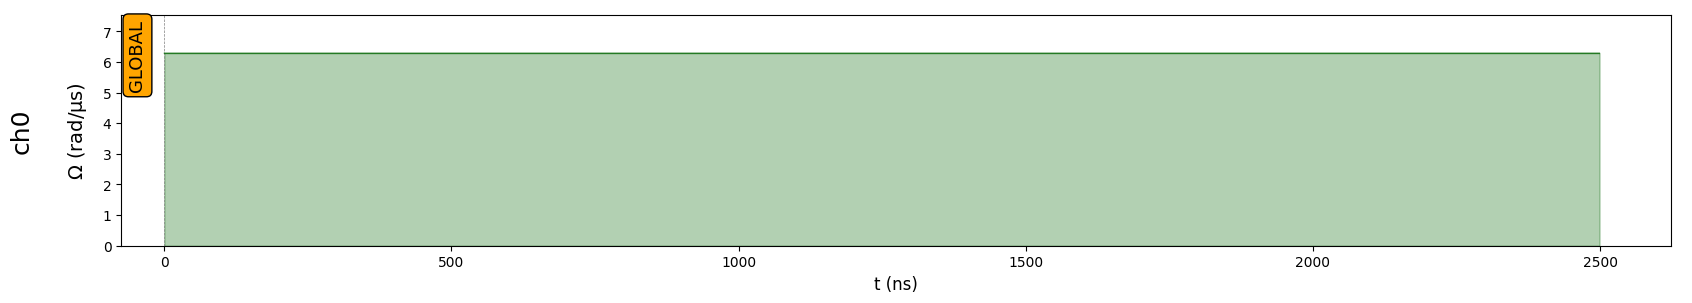

In [4]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

We now run the noiseless simulation, to obtain a `CoherentResults` object in `clean_res`. In order to characterize simuation results, we designed a dedicated class, the `SimulationResults` class. It has two child class, the `CoherentResults` for noiseless simulations and `NoisyResults` for noisy simulations. They allow to get useful information on the simulation parameters, the results of the simulation and more.

In [5]:
sim = Simulation(seq, sampling_rate=0.05)
clean_res = sim.run()

We can for instance ask for the basis or the dimension

In [8]:
print("Projection basis", clean_res._basis_name)
print("Dimension", clean_res._dim)

Projection basis ground-rydberg
Dimension 2


We can also plot the expectation values of an observable across time

In [10]:
# Rydberg state observable
obs = qutip.basis(2, 0).proj()

Then we can fund the population on the rydberg state towards time

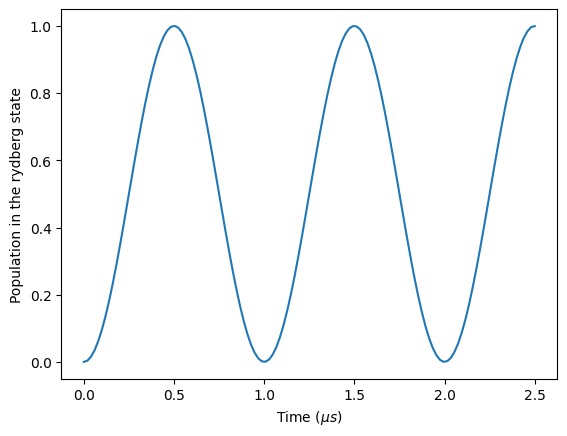

In [14]:
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Population in the rydberg state")
plt.show()

### The SimConfig object

Each simulation has an associated `SimConfig` object, which encapsulates parameters such as noise types, the temperature of the register and so on. You may view it at any time using the following command.

In [16]:
sim.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


When creating a new `SimConfig`, you may choose several parameters. `'runs'` indicates the number of times a noisy simulation is run to obtain the average result of several simulations, `'samples_per_run'` is the number of delivered samples per run - this has no physical interpretation, this is used simply to cut down on calculation time.

### SPAM noise use case

We will add as an example the `SPAM` noise to the simulation, in order to describe the different objects used for noisy simualtions. To do so, we can create a new `SimConfig` object, and assigning it to the `config` field of `sim` via the `Simulation.set_config` setter. We pass noise types as a tuple of strings to a SimConfig object. Possible strings are : `'SPAM', 'dephasing', 'doppler', 'amplitude'`.

In [25]:
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)
sim.set_config(config_spam)

We now show the new configuration to have an overview of the changes we made.

In [26]:
sim.show_config()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


Note that `SimConfig.spam_dict` is the spam parameters dictionary. `eta` is the probability of a badly prepared state, `epsilon` the false positive probability, `epsilon_prime` the false negative one.

When dealing with a `SimConfig` object with different noise parameters from the config in `Simulation.config`, you may "add" both configurations together, obtaining a single `SimConfig` with all noises from both configurations - on the other hand, the `runs` and `samples_per_run` will always be updated. This adds simulation parameters to noises that weren't available in the former `Simulation.config`. Noises specified in both `SimConfigs` will keep the noise parameters in `Simulation.config`. Try it out with `Simulation.add_config`:

In [27]:
cfg2 = SimConfig(
    noise=("SPAM", "dephasing", "doppler"),
    eta=0.8,
    temperature=1000,
    runs=50,
)
sim.add_config(cfg2)
sim.show_config()

Options:
----------
Number of runs:        50
Samples per run:       5
Noise types:           SPAM, dephasing, doppler
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}
Temperature:           1000.0µK
Amplitude standard dev.:  0.05
Dephasing probability: 0.05


Note that we set the temperature in $\mu K$. We also observe that the `eta` parameter wasn't changed, since both `SimConfig` objects had `'SPAM'` as a noise model already. This feature might be useful when running several simulations with distinct noise parameters to observe the influence of each noise independtly, then wanting to combine noises together without losing your tailored noise parameters.

We created a noisy simulation using `set_config` and `add_config` methods of the the Simulation class. But it's not the only way, you can directly create a noisy simulation when you create your simulation object.

In [28]:
sim = Simulation(
    seq,
    sampling_rate=0.05,
    config=SimConfig(
        noise=("SPAM", "dephasing", "doppler"),
        temperature=1000,
        runs=50,
    ),
)
sim.show_config()

Options:
----------
Number of runs:        50
Samples per run:       5
Noise types:           SPAM, dephasing, doppler
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}
Temperature:           1000.0µK
Amplitude standard dev.:  0.05
Dephasing probability: 0.05


### Setting evaluation times

As a `Simulation` field, `eval_times` refers to the times at which the result have to be returned. Choose `'Full'` for all the times the Hamiltonian has been sampled in the sequence, a list of times of your choice (has to be a subset of all times in the simulation), or a real number between $0$ and $1$ to sample the full return times array. Here, we choose to keep $\frac{8}{10}$ of the Hamiltonian sample times for our evaluation times.

In [29]:
sim.evaluation_times = 0.8

We now obtain a `NoisyResults` object from our noisy simulation. This object represents the final result as a probability distribution over the sampled bitstrings, rather than a quantum state `QObj` in the `CleanResults` case.

In [30]:
res = sim.run()

### Plotting noisy and clean results

The new `res` instance has similar methods to the usual `SimResults` object. For example, we can calculate expectation values. Observe how different the Rydberg population in the clean case and noisy case are : we clearly see a damping due to all the noises we added.

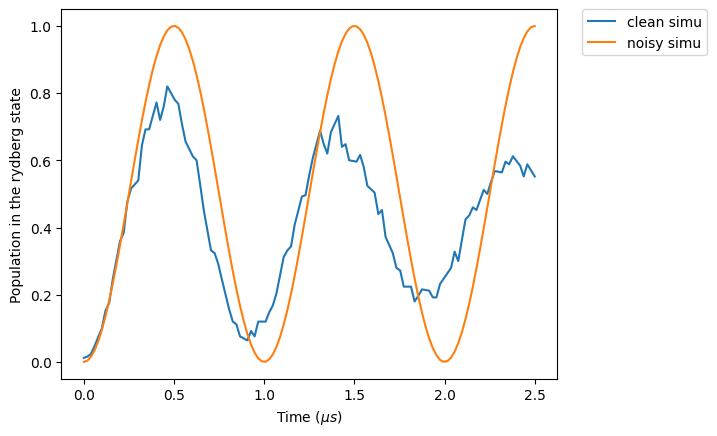

In [34]:
plt.plot(res._sim_times, res.expect([obs])[0], label="clean simu")
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0], label="noisy simu")
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel("Population in the rydberg state")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

You can also use the `SimResults.plot(obs)` method to plot expectation values of a given observable. Here we compute the `sigma_z` local operator expectation values. You may choose to add error bars using the argument `error_bars = True` (`True` by default for `NoisyResults`.) Be wary that computing the expectation value of non-diagonal operators will raise an error, as `NoisyResults` bitstrings are already projected on the $Z$ basis.

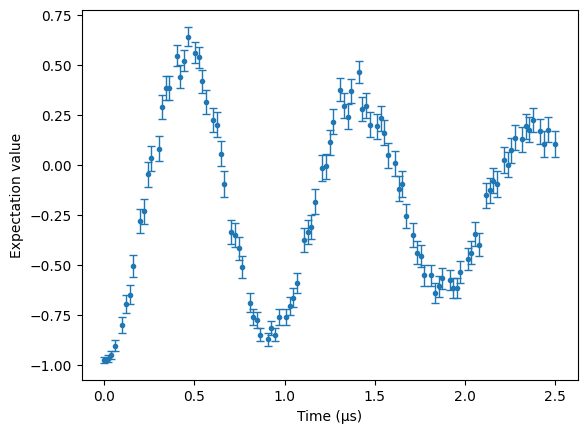

In [35]:
obs = qutip.sigmaz()
res.plot(obs, fmt=".")
plt.show()

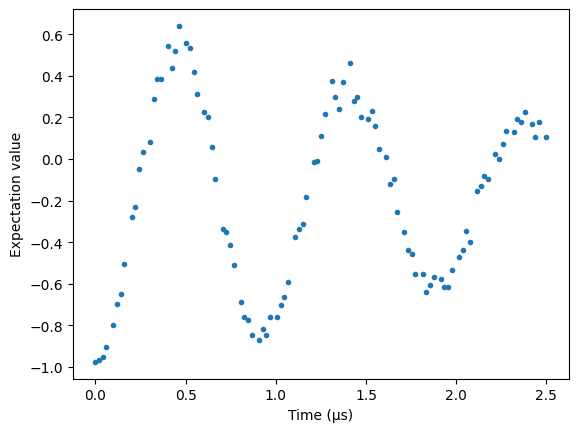

In [36]:
res.plot(obs, error_bars=False, fmt=".")

Now you have the basic knowledge to tackle noise simulations with pulser. In the following tutorials, we will see in details *Simulations with SPAM errors*, *Simulations with laser noises* and *Simulations with effective noises*.